In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 18})
plt.rcParams.update({"text.usetex": True,
                     "font.size": 14,
                     "pdf.fonttype": 42,
                     "ps.fonttype": 42})
plt.rcParams['xtick.labelsize']=12
# plt.rcParams.update(plt.rcParamsDefault)
import scipy.stats as st


In [2]:
def extractWinAroundMax(df, win_len=100):
  nrep = df['iter'].max()
  pruned_df = pd.DataFrame()
  for idx in range(nrep):
    try:
      idx_max_t = df[df['iter'] == idx+1]['latency'].idxmax()
      if idx_max_t<80:
        continue
      pruned_df = pd.concat([pruned_df, df.iloc[idx_max_t-win_len:idx_max_t+win_len,0:5]])
    except:
      pass
  return pruned_df

conf_perc_str = "99.9" #90%:1.645|95%:1.96|97%:2.17|99%:2.576|99.9%:3.29
  
def plot_confidence_interval_df(plt, stats_df, columnName, x_axis, color, coeff=1.96, norm=1):
  if columnName == "":
    subset_stats = stats_df[["mean", "count", "std"]]
  else:
    subset_stats = stats_df[["mean("+str(columnName)+")",
                             "count("+str(columnName)+")",
                             "std("+str(columnName)+")"]]
  norm_mean = []
  ci_high = []
  ci_low = []

  if (isinstance(norm, pd.DataFrame) or isinstance(norm, pd.Series)):
    if (len(stats_df["mean("+str(columnName)+")"].index) == len(norm.index)):
      for i in subset_stats.index:
        mean, count, std = subset_stats.loc[i]
        mean = mean/norm.loc[i]
        std = std/norm.loc[i]
        norm_mean.append(mean)
        ci_high.append(mean + coeff*std/np.sqrt(count))
        ci_low.append(mean - coeff*std/np.sqrt(count))
  else:
    for i in subset_stats.index:
      mean, count, std = subset_stats.loc[i]
      mean = mean/norm
      std = std/norm
      norm_mean.append(mean)
      ci_high.append(mean + coeff*std/np.sqrt(count))
      ci_low.append(mean - coeff*std/np.sqrt(count))

  plt.fill_between(x_axis, norm_mean, ci_high, alpha=0.3, color=color)
  plt.fill_between(x_axis, ci_low, norm_mean, alpha=0.3, color=color)

def filterByScenario (df_op):
  scenario_list=["ns_clear", "scp_ckpt", "create_ns","ns_clear_real", "scp_ckpt_real", "create_ns_real", "clear_arp","perf_ckpt","perf_restore"]
  filtered_df=pd.DataFrame()
  #filtered_df["iter"]=df_op["iter"].unique()
  for scenario in scenario_list:
    filtered_df[scenario] = df_op[df_op["scenario"] == scenario].reset_index()["elapsed"]
  return filtered_df

def mergeSockperfStats (df_latency, df_state, df_op, df_dump, df_restore):
  merged_df = pd.DataFrame()
  merged_df['iter'] = df_state["iter"]
  merged_df = pd.concat([merged_df, df_latency.groupby(['iter']).agg(max=('latency', 'max')).reset_index()['max']], axis="columns")
  merged_df = pd.concat([merged_df, df_state["memory_MB"]], axis="columns")
  merged_df = pd.concat([merged_df, filterByScenario(df_op)], axis="columns")
  df_dump_t = df_dump.drop("container_id", axis=1).drop("iter", axis=1)
  merged_df = pd.concat([merged_df, df_dump_t], axis="columns")
  df_restore_t = df_restore.drop("container_id", axis=1).drop("iter", axis=1)
  merged_df = pd.concat([merged_df, df_restore_t], axis="columns")
  return merged_df.rename({'max': 'max_latency', 'memory_MB': 'memory'}, axis='columns')

def get_margin_of_error( df_comumn, percentage=0.90):
  interval= st.t.interval(alpha=percentage, df=len(df_comumn)-1,
              loc=np.mean(df_comumn),
              scale=st.sem(df_comumn))
  margin_of_error =  df_comumn.mean() - interval[0]

  
  return margin_of_error

In [3]:
PATH = "../log/sockperf_ssh_delay/"
half_win_size=80
header_t = pd.read_csv(PATH + "sockperf.csv", sep=',', nrows=5)
dtypes = dict(zip(header_t.columns.values, ['uint16', 'uint16', 'float64', 'float64', 'float64']))
del header_t

raw_nonarp_df = pd.read_csv(PATH + "sockperf.csv", sep=',', dtype=dtypes)
raw_nonarp_df
pruned_nonarp_df = extractWinAroundMax(raw_nonarp_df, half_win_size).reset_index()
raw_sockperf_non_arp_latency_df = pruned_nonarp_df
raw_sockperf_non_arp_state_df = pd.read_csv(PATH + "container_state.csv", sep=',')
raw_sockperf_non_arp_op_df = pd.read_csv(PATH + "sockperf_op_time.csv", sep=',')
raw_sockperf_non_arp_dump_df = pd.read_csv(PATH + "podman_dump.csv", sep=',')
raw_sockperf_non_arp_restore_df = pd.read_csv(PATH + "podman_restore.csv", sep=',')
sockperf_non_arp_df = mergeSockperfStats(raw_sockperf_non_arp_latency_df, raw_sockperf_non_arp_state_df, raw_sockperf_non_arp_op_df, raw_sockperf_non_arp_dump_df, raw_sockperf_non_arp_restore_df)


In [6]:
PATH = "../log/iperf_ssh_delay/"
iperf_df = pd.read_csv(PATH + "iperf.csv", sep=',')
iperf_state_df = pd.read_csv(PATH + "container_state.csv", sep=',')
iperf_op_df = pd.read_csv(PATH + "iperf_op_time.csv", sep=',')
iperf_op_df=filterByScenario(iperf_op_df)
iperf_dump_df = pd.read_csv(PATH + "podman_dump.csv", sep=',')
iperf_restore_df = pd.read_csv(PATH + "podman_restore.csv", sep=',')

In [7]:
sockperf_non_arp_df.keys()

Index(['iter', 'max_latency', 'memory', 'ns_clear', 'scp_ckpt', 'create_ns',
       'ns_clear_real', 'scp_ckpt_real', 'create_ns_real', 'clear_arp',
       'perf_ckpt', 'perf_restore', 'podman_checkpoint_duration',
       'runtime_checkpoint_duration', 'freezing_time', 'frozen_time',
       'memdump_time', 'memwrite_time', 'pages_scanned', 'pages_written',
       'filesize', 'podman_restore_duration', 'runtime_restore_duration',
       'forking_time', 'restore_time', 'pages_restored'],
      dtype='object')

In [8]:
sockperf = pd.DataFrame()
sockperf["RTT"]= sockperf_non_arp_df["max_latency"]*2/1000
sockperf[["ns_clear","scp_ckpt","create_ns","ns_clear_real","scp_ckpt_real","create_ns_real"]] = sockperf_non_arp_df[["ns_clear","scp_ckpt","create_ns","ns_clear_real","scp_ckpt_real","create_ns_real"]]*1000
sockperf[["ckpt","restore"]]= sockperf_non_arp_df[["perf_ckpt","perf_restore"]]*1000
sockperf[["ckpt_real","restore_real"]]= sockperf_non_arp_df[["podman_checkpoint_duration","podman_restore_duration"]]/1000
sockperf["clear_arp"]=sockperf_non_arp_df["clear_arp"]*1000
sockperf["ssh_ns_clear"]= sockperf["ns_clear"]-sockperf["ns_clear_real"]
sockperf["ssh_scp_ckpt"]= sockperf["scp_ckpt"]-sockperf["scp_ckpt_real"]
sockperf["ssh_create_ns"]= sockperf["create_ns"]-sockperf["create_ns_real"]
sockperf["ssh_ckpt"]=sockperf["ckpt"]-sockperf["ckpt_real"]
sockperf["ssh_restore"]= sockperf["restore"]-sockperf["restore_real"]
sockperf["ssh_sum"]=sockperf["ssh_ns_clear"]+sockperf["ssh_scp_ckpt"]+sockperf["ssh_create_ns"]+sockperf["ssh_ckpt"]+sockperf["ssh_restore"]
sockperf["op_sum"]=sockperf["ns_clear_real"]+sockperf["scp_ckpt_real"]+sockperf["create_ns_real"]+sockperf["ckpt_real"]+sockperf["restore_real"]+sockperf["clear_arp"]
sockperf["ssh_est"]=sockperf["RTT"]-sockperf["op_sum"]
sockperf["mig_duration"] = sockperf["ssh_sum"]+sockperf["op_sum"]
drop_index = []
for i in range(len(sockperf)):
    if(sockperf.iloc[i]["RTT"]<1000  or sockperf.iloc[i]["ssh_ckpt"]>2000 or sockperf.iloc[i]["ssh_est"]>4000):
        drop_index.append(i)
sockperf.drop(drop_index, axis=0, inplace=True)

sockperf.shape

(33, 21)

In [9]:
sockperf.keys()

Index(['RTT', 'ns_clear', 'scp_ckpt', 'create_ns', 'ns_clear_real',
       'scp_ckpt_real', 'create_ns_real', 'ckpt', 'restore', 'ckpt_real',
       'restore_real', 'clear_arp', 'ssh_ns_clear', 'ssh_scp_ckpt',
       'ssh_create_ns', 'ssh_ckpt', 'ssh_restore', 'ssh_sum', 'op_sum',
       'ssh_est', 'mig_duration'],
      dtype='object')

## Sockperf real step analysis

In [10]:
selected_keys = ["ckpt","ns_clear","scp_ckpt","create_ns","clear_arp","restore","mig_duration","mig_duration"]
result_mean = []
ci_interval = []
result =[]
for key in selected_keys:
    mean= sockperf[key].mean()
    margin_of_error = get_margin_of_error(sockperf[key])
    result_mean.append(mean)
    ci_interval.append(margin_of_error)
    result.append( "{:.2f}".format(mean) + " ± " + "{:.2f}".format(margin_of_error))

for i in range(len(result_mean)):
    print("{:.2f}".format(ci_interval[i]/result_mean[i]*100))

2.08
3.14
0.99
1.34
8.54
1.95
1.30
1.30


In [11]:
print("Mean: ",sockperf["ckpt"].mean())
print("Std: ",sockperf["ckpt"].std())

Mean:  1745.3739483333334
Std:  122.98381895415173


In [12]:
print("Mean: ",sockperf["ns_clear"].mean())
print("Std: ",sockperf["ns_clear"].std())

Mean:  1013.9298314848486
Std:  108.06711986884332


In [13]:
print("Mean: ",sockperf["scp_ckpt"].mean())
print("Std: ",sockperf["scp_ckpt"].std())

Mean:  1698.5509298787879
Std:  56.7472069749881


In [14]:
print("Mean: ",sockperf["create_ns"].mean())
print("Std: ",sockperf["create_ns"].std())

Mean:  570.9750495454546
Std:  25.96584816557388


In [15]:
print("Mean: ",sockperf["clear_arp"].mean())
print("Std: ",sockperf["clear_arp"].std())

Mean:  115.35449427272728
Std:  33.426300594979814


In [16]:
print("Mean: ",sockperf["restore"].mean())
print("Std: ",sockperf["restore"].std())

Mean:  781.9097017878787
Std:  51.65296637823688


In [17]:
print("Mean: ",sockperf["mig_duration"].mean())
print("Std: ",sockperf["mig_duration"].std())

Mean:  5926.09395530303
Std:  261.39662797948085


In [18]:
print("Mean: ",sockperf["RTT"].mean())
print("Std: ",sockperf["RTT"].std())

Mean:  5110.904420363637
Std:  258.5958720690509


In [19]:
(sockperf["op_sum"]+sockperf["ssh_sum"]).mean()

5926.09395530303

In [20]:
sockperf["ssh_sum"].mean()

3259.78978730303

In [21]:
iperf = pd.DataFrame()
interrupt_down=[]
for i in range(50):
    interrupt_down.append((iperf_df.loc[(iperf_df['iter']==i+1) & (iperf_df['bps']==0)]['bps'].count())*100)
iperf["RTT"]= interrupt_down
iperf[["ns_clear","scp_ckpt","create_ns","ns_clear_real","scp_ckpt_real","create_ns_real"]] = iperf_op_df[["ns_clear","scp_ckpt","create_ns","ns_clear_real","scp_ckpt_real","create_ns_real"]]*1000
iperf[["ckpt","restore"]]= iperf_op_df[["perf_ckpt","perf_restore"]]*1000
iperf["ckpt_real"]= iperf_dump_df["podman_checkpoint_duration"]/1000
iperf["restore_real"]= iperf_restore_df["podman_restore_duration"]/1000
iperf["clear_arp"]=iperf_op_df["clear_arp"]*1000

iperf["ssh_ns_clear"]= iperf["ns_clear"]-iperf["ns_clear_real"]
iperf["ssh_scp_ckpt"]= iperf["scp_ckpt"]-iperf["scp_ckpt_real"]
iperf["ssh_create_ns"]= iperf["create_ns"]-iperf["create_ns_real"]
iperf["ssh_ckpt"]=iperf["ckpt"]-iperf["ckpt_real"]
iperf["ssh_restore"]= iperf["restore"]-iperf["restore_real"]
iperf["ssh_sum"]=iperf["ssh_ns_clear"]+iperf["ssh_scp_ckpt"]+iperf["ssh_create_ns"]+iperf["ssh_ckpt"]+iperf["ssh_restore"]
iperf["op_sum"]=iperf["ns_clear_real"]+iperf["scp_ckpt_real"]+iperf["create_ns_real"]+iperf["ckpt_real"]+iperf["restore_real"]+iperf["clear_arp"]
iperf["ssh_est"]=iperf["RTT"]-iperf["op_sum"]
iperf["mig_duration"] = iperf["ssh_sum"]+iperf["op_sum"]

iperf.shape


(50, 21)

In [22]:
selected_keys = ["ckpt","ns_clear","scp_ckpt","create_ns","clear_arp","restore","mig_duration","mig_duration"]
result_mean = []
ci_interval =[]
result =[]
for key in selected_keys:
    mean= iperf[key].mean()
    margin_of_error = get_margin_of_error(iperf[key])
    result_mean.append(mean)
    ci_interval.append(margin_of_error)
    result.append( "{:.2f}".format(mean) + " ± " + "{:.2f}".format(margin_of_error))

for i in range(len(result_mean)):
    print("{:.2f}".format(ci_interval[i]/result_mean[i]*100))

2.26
4.14
1.04
0.67
2.72
2.35
1.19
1.19


In [23]:
print("Mean: ",iperf["ckpt"].mean())
print("Std: ",iperf["ckpt"].std())

Mean:  1418.7398148
Std:  135.12203367354087


In [24]:
print("Mean: ",iperf["ns_clear"].mean())
print("Std: ",iperf["ns_clear"].std())

Mean:  670.69380686
Std:  117.07566287280436


In [25]:
print("Mean: ",iperf["scp_ckpt"].mean())
print("Std: ",iperf["scp_ckpt"].std())

Mean:  1085.6885042000001
Std:  47.66098730014339


In [26]:
print("Mean: ",iperf["create_ns"].mean())
print("Std: ",iperf["create_ns"].std())

Mean:  502.56999132000004
Std:  14.271063976082967


In [27]:
print("Mean: ",iperf["clear_arp"].mean())
print("Std: ",iperf["clear_arp"].std())

Mean:  68.86694742
Std:  7.9128596794428185


In [28]:
print("Mean: ",iperf["restore"].mean())
print("Std: ",iperf["restore"].std())

Mean:  704.87570286
Std:  69.86101241117437


In [29]:
print("Mean: ",iperf["mig_duration"].mean())
print("Std: ",iperf["mig_duration"].std())

Mean:  4451.43476746
Std:  222.60035003401418


In [30]:
print("Mean: ",iperf["RTT"].mean())
print("Std: ",iperf["RTT"].std())

Mean:  3708.0
Std:  241.45815541481826


In [31]:
(iperf["op_sum"]+iperf["ssh_sum"]).std()

222.60035003401418

In [32]:
iperf["ssh_sum"].mean()

2584.00624386

## Problem plot

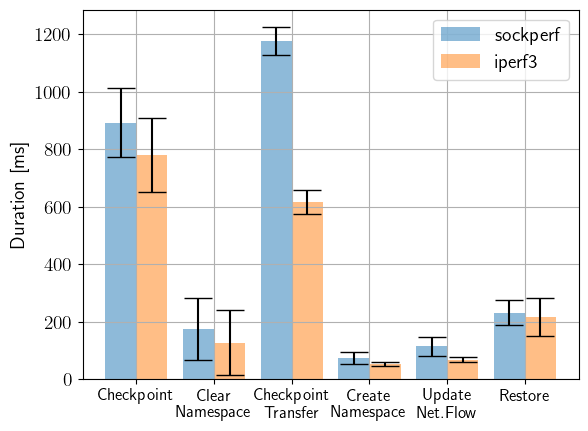

In [33]:
x_label = ["Checkpoint","Clear\nNamespace","Checkpoint\nTransfer","Create\nNamespace","Update\nNet.Flow","Restore"]
x_pos = np.array(range(len(x_label)))

plt.figure()

temp1 = sockperf[["ckpt_real","ns_clear_real","scp_ckpt_real","create_ns_real","clear_arp","restore_real"]]
temp2 = iperf[["ckpt_real","ns_clear_real","scp_ckpt_real","create_ns_real","clear_arp","restore_real"]]
plt.bar(x_pos - 0.2, temp1.mean().values, 0.4,yerr=temp1.std().values, align='center', alpha=0.5, ecolor='black', capsize=10, label = 'sockperf')
plt.bar(x_pos + 0.2, temp2.mean().values, 0.4,yerr=temp2.std().values, align='center', alpha=0.5, ecolor='black', capsize=10, label = 'iperf3')

plt.xticks(x_pos, x_label)
plt.ylabel("Duration [ms]")
plt.legend()
plt.grid()
plt.savefig("../figures/breakdown.pdf",format="pdf")

## SSH delay measurements

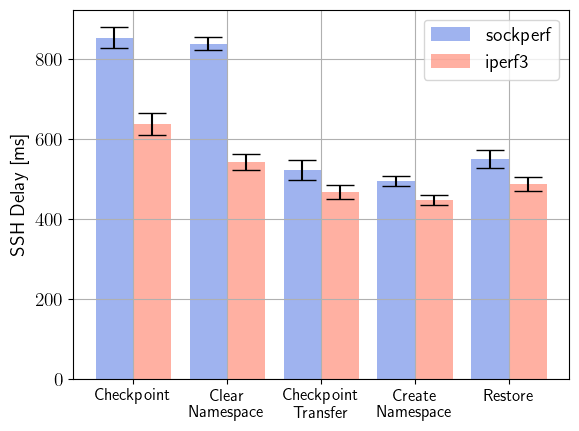

In [34]:
x_label = ["Checkpoint","Clear\nNamespace","Checkpoint\nTransfer","Create\nNamespace","Restore"]
x_pos = np.arange(len(x_label))

temp1 = sockperf[["ssh_ckpt","ssh_ns_clear","ssh_scp_ckpt","ssh_create_ns","ssh_restore"]]
temp2 = iperf[["ssh_ckpt","ssh_ns_clear","ssh_scp_ckpt","ssh_create_ns","ssh_restore"]]

plt.figure()
plt.bar(x_pos - 0.2,temp1.mean().values , 0.4,yerr=temp1.std().values,color='royalblue', align='center', alpha=0.5, ecolor='black', capsize=10, label = 'sockperf')
plt.bar(x_pos + 0.2, temp2.mean().values, 0.4,yerr=temp2.std().values,color='tomato', align='center', alpha=0.5, ecolor='black', capsize=10, label = 'iperf3')

plt.xticks(x_pos, x_label)
plt.ylabel("SSH Delay [ms]")
plt.legend()
plt.grid()
# plt.show()
plt.savefig("../figures/ssh_delays.pdf",format="pdf")